In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import os
import random
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  pmdarima.arima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
import tensorflow.keras as keras
import warnings
warnings.simplefilter("ignore")

time: 1.77 s (started: 2022-06-24 04:30:55 +00:00)


# Prepare data

In [ ]:
stock_price_df = pd.read_csv("./stock08_price.csv")

universe = list(stock_price_df.columns.values[1:])
universe.remove("SP500")
# train data
portfolio_train = ['CELG', 'PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'CRM', 'NEM', 'JNPR', 'LB', 'CTAS', 'MAT', 'MDLZ', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'GRMN', 'CI', 'ZION', 'COO', 'TIF', 'RHT', 'FDX', 'LLL', 'GLW', 'GPN', 'IPGP', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'AAP', 'DAL', 'A', 'MON', 'BRK', 'BMY', 'KMB', 'JPM', 'CCI', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'UPS', 'WMB', 'IFF', 'CMS', 'ARNC', 'VIAB', 'MMC', 'REG', 'ES', 'ITW', 'NDAQ', 'AIZ', 'VRTX', 'CTL', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'EXR', 'VNO', 'BBT', 'WDC', 'UAL', 'PVH', 'NOC', 'PCAR', 'NSC', 'UAA', 'FFIV', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'CMG', 'ALK', 'ULTA', 'TMK', 'TAP', 'SCG', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'WU', 'ACN', 'HIG', 'TEL', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'ETFC', 'CMA', 'NRG', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'CBS', 'ALGN', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'XLNX', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG', 'FOX', 'MA']
# all data
portfolio_all = universe
# all data - train data
portfolio_other = [p for p in universe if p not in portfolio_train]
print(len(portfolio_train), len(portfolio_all), len(portfolio_other))

pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))

In [ ]:
def gen_unseen_data_corr(portfolio):
    tmp_corr = stock_price_df[portfolio[0]].rolling(window=100).corr(stock_price_df[portfolio[1]])
    tmp_corr = tmp_corr.iloc[99::100]
    tmp_corr = tmp_corr[len(tmp_corr)-21:len(tmp_corr)]
    unseen_data_df = pd.DataFrame(tmp_corr).reset_index().drop(['Date'],axis=1).T
    return unseen_data_df

# ARIMA model

In [ ]:
# dataset = pd.read_csv('./stock_correlation_prediction/use_hybrid_model/before_arima/unseen_data.csv')
# dataset = dataset.loc[:,~dataset.columns.str.contains('Unnamed')]

# model_110 = ARIMA(order=(1,1,0), mle_regression=True, suppress_warnings=True)
# model_011 = ARIMA(order=(0,1,1), mle_regression=True, suppress_warnings=True)
# model_111 = ARIMA(order=(1,1,1), mle_regression=True, suppress_warnings=True)
# model_211 = ARIMA(order=(2,1,1), mle_regression=True, suppress_warnings=True)
# model_210 = ARIMA(order=(2,1,0), mle_regression=True, suppress_warnings=True)
def arima_model(dataset, overview=False):
    model_110 = ARIMA(order=(1,1,0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_011 = ARIMA(order=(0,1,1), out_of_sample_size=0,  mle_regression=True, suppress_warnings=True)
    model_111 = ARIMA(order=(1,1,1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_211 = ARIMA(order=(2,1,1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_210 = ARIMA(order=(2,1,0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_330 = ARIMA(order=(3,3,0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)


    flag = 0
    c=0
    residual = []
    for s in np.array(dataset):
        c+=1
        try:
            model1 = model_110.fit(s)
            arima_model = model1
            model_title = "model_110"

            try:
                model2 = model_011.fit(s)

                if model.aic() <= model2.aic() :
                    pass
                else :
                    arima_model = model2
                    model_title = "model_011"

                try :
                    model3 = model_111.fit(s)
                    if model.aic() <= model3.aic() :
                        pass
                    else :
                        arima_model = model3
                        model_title = "model_111"
                except :
                    try:
                        model4 = model_211.fit(s)

                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            arima_model = model4
                            model_title = "model_211"
                    except:
                        try:
                            model5 = model_210.fit(s)

                            if model.aic() <= model5.aic():
                                pass
                            else :
                                arima_model = model5
                                model_title = "model_210"
                        except :
                            pass

            except:
                try:
                    model3 = model_111.fit(s)

                    if model.aic() <= model3.aic() :
                        pass
                    else :
                        arima_model = model3
                        model_title = "model_111"
                except :
                    try:
                        model4 = model_211.fit(s)

                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            arima_model = model4
                            model_title = "model_211"
                    except:
                        try:
                            model5 = model_210.fit(s)

                            if model.aic() <= model5.aic():
                                pass
                            else :
                                arima_model = model5
                                model_title = "model_210"
                        except :
                            pass

        except:
            try:
                model2 = model_011.fit(s[i])
                arima_model = model2
                model_title = "model_011"

                try :
                    model3 = model_111.fit(s[i])

                    if model.aic() <= model3.aic():
                        pass
                    else:
                        arima_model = model3
                        model_title = "model_111"
                except :
                    try:
                        model4 = model_211.fit(s[i])

                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            arima_model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])

                            if model.aic() <= model5.aic():
                                pass
                            else :
                                arima_model = model5
                        except :
                            pass

            except :
                try:
                    model3 = model_111.fit(s[i])
                    arima_model = model3
                except :
                    try:
                        model4 = model_211.fit(s[i])

                        if model.aic() <= model4.aic() :
                            pass
                        else:
                            arima_model = model4
                    except:
                        try:
                            model5 = model_210.fit(s[i])

                            if model.aic() <= model5.aic():
                                pass
                            else :
                                arima_model = model5
                        except :
                            flag = 1
                            print(str(c) + " FATAL ERROR")
                            break


        arima_pred = list(arima_model.predict_in_sample())
        arima_pred = [np.mean(arima_pred[1:])] + arima_pred[1:]

        res = pd.Series(np.array(s) - np.array(arima_pred))
        residual.append(np.array(res)[:20])


        if flag == 1:
            break
    residual = pd.DataFrame(residual)
    
    if overview:
        plt.plot(arima_pred, label="arima_pred")
        plt.plot(dataset.T, label="data")
        plt.plot(res, label="res")
        plt.legend()
        plt.show()
        plt.close()
    
    return arima_pred, residual

# LSTM

In [ ]:
class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'

def double_tanh(x):
    return (K.tanh(x) * 2)

get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})

filepath = './stock_correlation_prediction/models/hybrid_LSTM/epoch262.h5'
custom_objects = {"Double_Tanh": Double_Tanh}
with keras.utils.custom_object_scope(custom_objects):
    lstm_model = load_model(filepath)

# Hybrid model

In [ ]:
res_list = []
count = 0
for portfolio in tqdm(combinations(portfolio_other,2)):
    unseen_data_corr = gen_unseen_data_corr(portfolio)
    arima_pred, residual = arima_model(unseen_data_corr)
    unseen_res = residual.values.reshape((-1,20,1))
    lstm_pred = lstm_model.predict(unseen_res)
    portfolio_res_dic = {"portfolio":f"{portfolio[0]} & {portfolio[1]}", "lstm_pred":lstm_pred[0][0], "arima_pred": arima_pred[-1], "hybrid_model_pred":arima_pred[-1]+lstm_pred[0][0], "ground_truth": unseen_data_corr.iloc[0, -1], "mae":mean_absolute_error(unseen_data_corr.iloc[0, -1].reshape(-1), (arima_pred[-1]+lstm_pred[0][0]).reshape(-1)), "lstm_compensation_dir": np.sign(unseen_data_corr.iloc[0, -1] - arima_pred[-1])*np.sign(lstm_pred[0][0])}
    res_list.append(portfolio_res_dic)


In [2]:
res_df = pd.DataFrame(res_list)
res_df.to_csv("./stock_correlation_prediction/use_hybrid_model/295stocks_res.csv")

,Unnamed: 0,portfolio,lstm_pred,arima_pred,hybrid_model_pred,ground_truth,mae,lstm_compensation_dir
0,0,RCL & CXO,0.348715,-0.229908,0.118807,0.410875,0.292068,1.0
1,1,RCL & AKAM,0.356152,0.011656,0.367808,0.460247,0.092439,1.0
2,2,RCL & WM,-0.065107,0.579939,0.514831,0.649687,0.134856,-1.0
3,3,RCL & EBAY,-0.452927,0.495374,0.042447,0.018734,0.023714,1.0
4,4,RCL & GIS,-0.086733,-0.061852,-0.148586,-0.256230,0.107644,1.0
...,...,...,...,...,...,...,...,...
43360,43360,EMR & RSG,0.047883,0.016578,0.064460,0.262464,0.198004,1.0
43361,43361,EMR & DIS,-0.381670,0.059561,-0.322109,-0.547388,0.225279,1.0
43362,43362,CNP & RSG,-0.660162,0.776329,0.116167,0.205933,0.089766,1.0
43363,43363,CNP & DIS,-0.545030,-0.016643,-0.561673,-0.670575,0.108902,1.0


time: 80.2 ms (started: 2022-06-24 04:31:00 +00:00)


# Display results

In [6]:
res_df = pd.read_csv("./stock_correlation_prediction/use_hybrid_model/295stocks_res.csv")
display(res_df)

<AxesSubplot:>

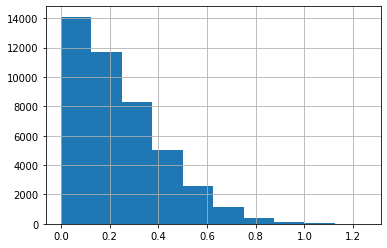

time: 72.9 ms (started: 2022-06-24 04:55:42 +00:00)


In [6]:
res_df['mae'].hist()

In [ ]:
sns.set(color_codes=True)
sns.set_style("white")
df = sns.load_dataset('iris')
sns.violinplot( y=df["sepal_length"] )